### E10S Experiment Aurora (crash rate)

[Bug 1222890](https://bugzilla.mozilla.org/show_bug.cgi?id=1222890)

This analysis tracks crash rate differences between e10s and non-e10s.

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py
import IPython

from __future__ import division
from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

%pylab inline
IPython.core.pylabtools.figsize(16, 7)

Unable to parse whitelist (/home/hadoop/anaconda/lib/python2.7/site-packages/moztelemetry/bucket-whitelist.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

128

#### Get e10s and non-e10s partitions

In [3]:
def is_in_e10s_experiment(ping):
    try:
        experiment = ping["environment"]["addons"]["activeExperiment"]
        return experiment["id"] == "e10s-enabled-aurora-20151020@experiments.mozilla.org" and \
               (experiment["branch"] == "control" or experiment["branch"] == "experiment")   
    except:
        return False

In [4]:
def is_e10s_ping(ping):
    return ping["environment"]["settings"]["e10sEnabled"]

In [5]:
def strip_date(date):
    return date[:10].replace("-", "")

def is_sensible_creation_date(ping):
    creation_date = strip_date(ping["creationDate"])
    submission_date = strip_date(ping["meta"]["submissionDate"])
    return creation_date == submission_date

### Pings

In [6]:
PER_ADI = 100
PING_OPTIONS = { "app": "Firefox", "channel": "aurora", "version": "43.0a2", "submission_date": ("20151023", "20151027") }

In [7]:
session_pings = get_pings(sc, **PING_OPTIONS).filter(is_in_e10s_experiment).filter(is_sensible_creation_date)

Make sure it's not the first session ping as the experiment branch will not be enforced until the next restart

In [8]:
# TODO: Add get_ping_properties to moztelemetry?
def get_ping_properties(ping, paths, only_median=False, with_processes=False):
    from moztelemetry.spark import _get_ping_properties
    if type(paths) == str:
        paths = [paths]

    # Use '/' as dots can appear in keyed histograms
    paths = [(path, path.split("/")) for path in paths]
    return _get_ping_properties(ping, paths, only_median, with_processes)

first_session_ping_of_client = \
      session_pings.map(lambda p: (p["clientId"], p))\
     .reduceByKey(lambda x, y: x if x["meta"]["creationTimestamp"] < y["meta"]["creationTimestamp"] else y)\
     .map(lambda p: (p[0], get_ping_properties(p[1], ["meta/documentId", "meta/creationTimestamp"])))\
     .collectAsMap()

In [9]:
def not_first_session(ping):
    return not ping["meta"]["documentId"] in first_session_ping_of_client[ping["clientId"]]["meta/documentId"]

session_pings = session_pings.filter(not_first_session)

In [10]:
e10s_session_pings = session_pings.filter(lambda p: is_e10s_ping(p))
non_e10s_session_pings = session_pings.filter(lambda p: not is_e10s_ping(p))

How many crashes did we have in total?

In [11]:
crash_pings = get_pings(sc, doc_type="crash", **PING_OPTIONS).filter(is_in_e10s_experiment).filter(is_sensible_creation_date)

In [12]:
crash_pings.count()

5872

How many crash pings don't have a clientId?

In [13]:
def has_client_id(ping):
    return ping.get("clientId")

crash_pings.filter(lambda p: not has_client_id(p)).count()

8

Exclude them

In [14]:
crash_pings = crash_pings.filter(has_client_id)

How many crash pings occured before the first session ping?

In [15]:
def is_after_first_session_timestamp(ping):
    first_session_ping = first_session_ping_of_client.get(ping["clientId"])
    return first_session_ping and ping["meta"]["creationTimestamp"] > first_session_ping["meta/creationTimestamp"]

crash_pings.filter(lambda p: not is_after_first_session_timestamp(p)).count()

1171

Exclude them

In [16]:
crash_pings = crash_pings.filter(is_after_first_session_timestamp)

In [17]:
e10s_crash_pings = crash_pings.filter(lambda p: is_e10s_ping(p))
non_e10s_crash_pings = crash_pings.filter(lambda p: not is_e10s_ping(p))

### Crashes per ADI

In [18]:
def get_crash_rate_per_day(sessions, crashes):
    sessions_per_day = sessions.map(lambda p: (strip_date(p["creationDate"]), 0)).countByKey()
    crashes_per_day = crashes.map(lambda p: (strip_date(p["payload"]["crashDate"]), 0)).countByKey()
    return { k: (float(crashes_per_day.get(k, 0)) / sessions_per_day.get(k, 1)) * PER_ADI for k in set(sessions_per_day) }

In [19]:
e10s_crash_rate_per_day = get_crash_rate_per_day(e10s_session_pings, e10s_crash_pings)

In [20]:
non_e10s_crash_rate_per_day = get_crash_rate_per_day(non_e10s_session_pings,  non_e10s_crash_pings)

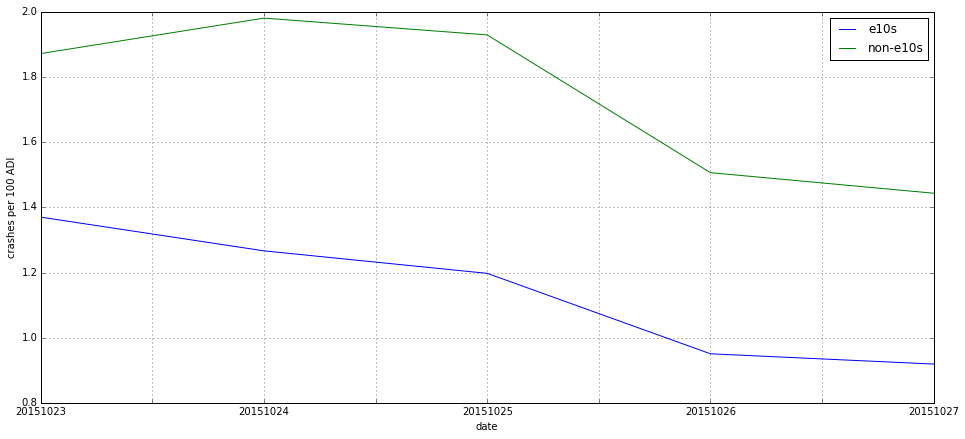

In [21]:
data = { "e10s": pd.Series(e10s_crash_rate_per_day),
         "non-e10s": pd.Series(non_e10s_crash_rate_per_day) }
df = pd.DataFrame(data)
df.plot()
plt.xlabel("date")
plt.ylabel("crashes per %d ADI" % PER_ADI)
plt.show()

### Crashes per client

In [22]:
def get_crashes_per_client(crashes):
    return crashes.map(lambda p: (p["clientId"], 0)).countByKey()

In [23]:
e10s_crashes_per_client = get_crashes_per_client(e10s_crash_pings)

In [24]:
non_e10s_crashes_per_client = get_crashes_per_client(non_e10s_crash_pings)

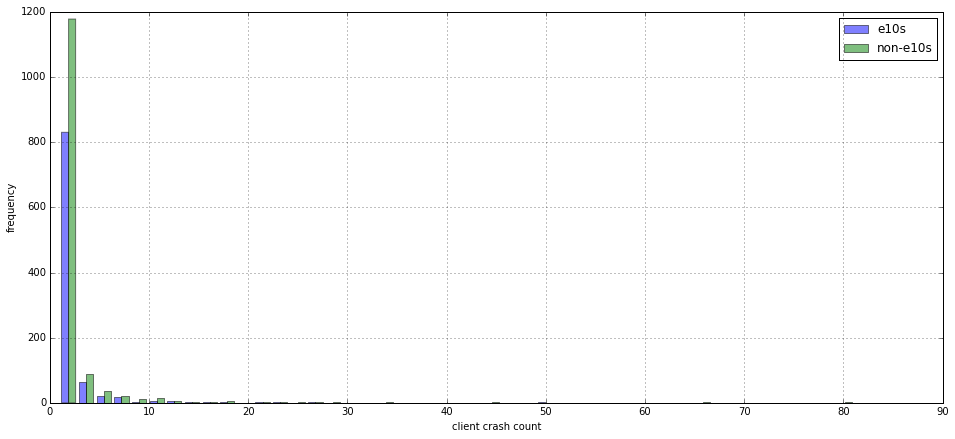

In [25]:
data = (e10s_crashes_per_client.values(), non_e10s_crashes_per_client.values())
plt.hist(data, label=("e10s", "non-e10s"), histtype='bar', bins=45, alpha=0.5)
plt.grid(True)
plt.xlabel("client crash count")
plt.ylabel("frequency")
plt.legend()
plt.show()